In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import os

import pyFM.spectral as spectral
from pyFM.mesh import TriMesh

from tqdm.auto import tqdm
import meshplot as mp

def double_plot_o3d(myMesh1,myMesh2,cmap1=None,cmap2=None):
    vertlist_1 = np.asarray(myMesh1.vertices)
    facelist_1 = np.asarray(myMesh1.triangles)

    vertlist_2 = np.asarray(myMesh2.vertices)
    facelist_2 = np.asarray(myMesh2.triangles)
    
    d = mp.subplot(vertlist_1, facelist_1, c=cmap1, s=[2, 2, 0])
    mp.subplot(vertlist_2, facelist_2, c=cmap2, s=[2, 2, 1], data=d)

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Data Pre-Processing ____________________________________
(need to change this back to just doing it with o3d rather than TriMesh)
1. Load Meshes
2. Generate Intial Point to Point Maps 
3. Convert to Functional Maps

In [46]:
path = os.path.abspath('../simulation/meshes_dancer')

start_frame = 1
end_frame = 20
frames = [str(i).zfill(4) for i in range(start_frame, end_frame + 1)]

# load meshes
mesh_list_o3d = [o3d.io.read_triangle_mesh(f'{path}/frame_{frame}.ply') for frame in tqdm(frames)]

mesh_list = []
for mesh in tqdm(mesh_list_o3d):
    
    mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=3000 * 2)  # ~2 faces per vertex
    verts, faces = np.asarray(mesh_simplified.vertices), np.asarray(mesh_simplified.triangles)
    
    mesh_pyfm = TriMesh(verts, faces, area_normalize=True, center=True)
    mesh_pyfm.process(k=150, intrinsic=True)
    mesh_list.append(mesh_pyfm)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
def initial_p2p_map(verts_i, verts_j):

    pcd_j = o3d.geometry.PointCloud() # create pointcloud
    pcd_j.points = o3d.utility.Vector3dVector(verts_j) # assign verts with normals to cloud

    kdtree = o3d.geometry.KDTreeFlann(pcd_j)
    
    p2p_ji = []
    for vert in verts_i:
        [_, idx, _] = kdtree.search_knn_vector_3d(vert, 1) 
        p2p_ji.append(idx[0])

    p2p_ji = np.array(p2p_ji)
    return p2p_ji

# Test Display
mesh_1 = mesh_list_o3d[0]; mesh_2 = mesh_list_o3d[1]
verts_1 = np.asarray(mesh_1.vertices)
verts_2 = np.asarray(mesh_2.vertices)

p2p_map = initial_p2p_map(verts_1,verts_2)
cmap_1 = visu(verts_1)
cmap_2 = cmap_1[p2p_map]

double_plot_o3d(mesh_1, mesh_2, cmap_1,cmap_2)

In [50]:
K = 30 # intial dimensions
maps_dict = {}
n_meshes = len(mesh_list)

for i in tqdm(range(n_meshes)):
    for j in range(n_meshes):
        if i == j: 
            continue # skip self-maps

        mesh_i, mesh_j = mesh_list[i], mesh_list[j]

        verts_i, verts_j = np.asarray(mesh_i.vertices), np.asarray(mesh_j.vertices)
        p2p_ji = initial_p2p_map(verts_j, verts_i)

        # Convert to functional map
        FM_ij = spectral.mesh_p2p_to_FM(p2p_ji, mesh_i, mesh_j, dims=K)
    
    # Populate the dictionary
    maps_dict[(i, j)] = FM_ij

  0%|          | 0/20 [00:00<?, ?it/s]

## Consistent Zoomout _______________________________________________
1. Create Functional Map Network (FMN)
2. Run ConsistentZoomout refinement
3. Visualise Results by converting refined maps back to point to point maps

In [27]:
from pyFM.FMN import FMN

# Build the network
fmn_model = FMN(mesh_list, maps_dict.copy())
#fmn_model.compute_CCLB(m=20)

# Run Consistent Zoomout
fmn_model.zoomout_refine(nit=25, step=2, subsample=1000, isometric=True, weight_type='icsm',
                    M_init=None, cclb_ratio=.9, n_jobs=1, equals_id=False,
                    verbose=True)

Setting 20 edges on 20 nodes.
Computing a 1000-sized subsample for each mesh


  0%|          | 0/24 [00:00<?, ?it/s]

/home/humense/anaconda3/envs/capstone/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/humense/anaconda3/envs/capstone/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


RuntimeError: Factor is exactly singular

In [51]:
K = 30
maps_dict = {}

def subsample_mesh(verts, n_samples=3000):
    if len(verts) <= n_samples:
        return verts, np.arange(len(verts))
    idx = np.random.choice(len(verts), size=n_samples, replace=False)
    return verts[idx], idx

n_meshes = len(mesh_list)
for i in tqdm(range(n_meshes)):
    for j in range(n_meshes):
        if i == j:
            continue

        verts_i, verts_j = np.asarray(mesh_list[i].vertices), np.asarray(mesh_list[j].vertices)

        # Subsample
        verts_i_sub, idx_i = subsample_mesh(verts_i)
        verts_j_sub, idx_j = subsample_mesh(verts_j)

        # Compute p2p map on subsampled vertices
        p2p_sub = initial_p2p_map(verts_j_sub, verts_i_sub)

        # Lift to full mesh safely
        p2p_ji = np.full(len(verts_j), 0, dtype=int)  # <-- use 0, not -1
        p2p_ji[idx_j] = idx_i[p2p_sub]

        maps_dict[(i, j)] = spectral.mesh_p2p_to_FM(p2p_ji, mesh_list[i], mesh_list[j], dims=K)

# Build FMN
fmn_model = FMN(mesh_list, maps_dict)

# Zoomout refine
fmn_model.zoomout_refine(
    nit=25,
    step=2,
    subsample=3000,
    isometric=True,
    weight_type='icsm',
    M_init=None,
    cclb_ratio=.9,
    n_jobs=1,
    equals_id=False,
    verbose=True
)


  0%|          | 0/20 [00:00<?, ?it/s]

Setting 380 edges on 20 nodes.
Computing a 3000-sized subsample for each mesh


  0%|          | 0/24 [00:00<?, ?it/s]

In [52]:
import pickle as p

# save
with open("../fmn_model_MESHES.pkl", "wb") as f:
    p.dump(fmn_model, f)

# I might also save the refined maps_dict

# # load
# with open("../fmn_model_CZ.pkl", "rb") as f:
#     fmn_model = p.load(f)

## Evaulate Model Perfromance and Results _____________________ [not working]

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fmn_model.compute_CCLB(m=int(0.9*fmn_model.M))
fmn_model.cclb_eigenvalues.shape
all_embs_a = []
all_embs_c = []

for i in range(fmn_model.n_meshes):
    CSD_a, CSD_c = fmn_model.get_CSD(i)

    all_embs_a.append(CSD_a.flatten())
    all_embs_c.append(CSD_c.flatten())

all_embs_a = np.array(all_embs_a)
all_embs_c = np.array(all_embs_c)

pca_model = PCA(n_components=2)
emb_red_a = pca_model.fit_transform(all_embs_a)
emb_red_c = pca_model.fit_transform(all_embs_c)


Optimizing Cycle Weights...
	Done in 0.01266s
Computing 78 CLB eigenvectors...
	Done in 0.5s


Text(0.5, 1.0, 'Conformal CSD')

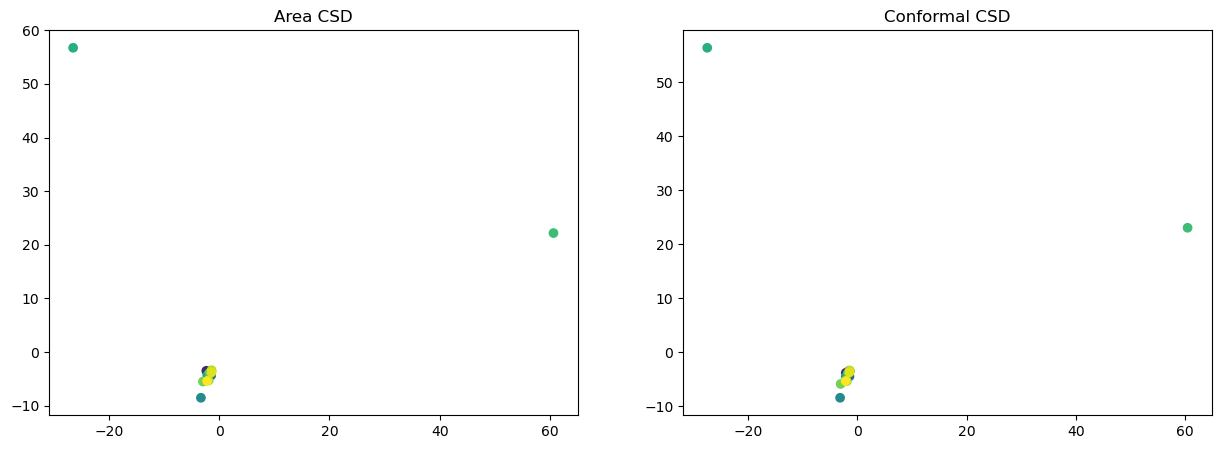

In [54]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(emb_red_a[:, 0], emb_red_a[:, 1], c=np.arange(len(emb_red_a)))
axs[0].set_title('Area CSD')

axs[1].scatter(emb_red_c[:, 0], emb_red_c[:, 1], c=np.arange(len(emb_red_c)))
axs[1].set_title('Conformal CSD')

In [55]:
# For Display
ind_1 = 0 # mesh 2 is the horse
ind_2 = 1 # mesh 4 is the wolf

new_maps_dict = fmn_model.maps
map = new_maps_dict[(ind_1, ind_2)]
mesh1, mesh2 = mesh_list[ind_1], mesh_list[ind_2]

mesh1_o3d, mesh2_o3d = mesh_list_o3d[ind_1], mesh_list_o3d[ind_2]
verts_o3d = np.asarray(mesh1_o3d.vertices)

p2p_21 = spectral.convert.mesh_FM_to_p2p(map, mesh1, mesh2)

cmap_1 = visu(mesh1.vertlist) # pointwise is 2 -> 1? so the map is applied to ?
cmap_2 = cmap_1[p2p_21]
double_plot(mesh1, mesh2, cmap_1, cmap_2)